## Science Data Analysis (Science frame correction)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from astropy.io import fits 
import pickle 

In [3]:
ls

Figure 14.png                    correctAF87320err.p
Untitled.ipynb                   correctAF87321.p
aperture_photometry.ipynb        correctAF87321err.p
aperturephotometry_class.ipynb   correctAF87322.p
bias/                            correctAF87322err.p
bias.ipynb                       correctAF87323.p
bias_stack.p                     correctAF87323err.p
centroid_measurement.ipynb       differential_photometry.ipynb
classing.py                      flat/
correct/                         flat.ipynb
correctAF87314.p                 flat_normalization_factors.p
correctAF87314err.p              flat_normalized_stack.p
correctAF87315.p                 flat_stack.p
correctAF87315err.p              image.jpg
correctAF87316.p                 median_bias.p
correctAF87316err.p              median_bias_error.p
correctAF87317.p                 median_bias_error_value.p
correctAF87317err.p              median_normalized_flat.p
correctAF87318.p                 median_normalized_flat_errors.p
co

In [4]:
science_list=np.genfromtxt("./science/science.list", dtype='str')

In [5]:
print(len(science_list))

1233


This is too many images for the computer, so we must do correction 'On the Fly', we save only the final outcome, and no intermediate data products. This is done on missions like PLATO (aperture photometry done on the satellite, only final data products are sent down. Happens with SMAP too!

We must check that we are doing things correctly on a small subsample (10-20 images)  then you do it for the hundreds or thousands of images. 

In [6]:
# обычно содержат сохранённые Python-объекты

median_bias=pickle.load(open('median_bias.p','rb')) 
# Загружает объект из файла median_bias.p
#rb означает "read binary" — файл открывается для чтения в двоичном режиме
# данные о медианном смещении

median_bias_error=pickle.load(open('median_bias_error.p','rb'))
# данные об ошибке, связанной с медианным смещением

median_normalized_flat=pickle.load(open('median_normalized_flat.p','rb'))
# данные о нормализованном медианном плоском поле

median_normalized_flat_errors=pickle.load(open('median_normalized_flat_errors.p','rb'))
#данные об ошибке нормализованного плоского поля


bias_std = 1.31 # [e] photoelectrons: Median STD of each pixel
readout_noise = 7.38  # [e] photoelectrons: STD single frame
gain = 2.73 # [e/ADU] : as extracted from the header of a bias frame


In [7]:
science_test_list=science_list[:10]
len(science_test_list)

10

### Data reduction steps
Science **data reduction** includes these steps:

(the process of transforming raw scientific data into a form suitable for analysis)

1. multiplication by gain
2. bias subtraction
3. division by flat

These components contribute to the **error** budget:

1. readout noise
2. error associated with the bias
3. error associated with the flat
4. photon noise

For the photon noise, we can rely on Poissonian distribution as done with the flat

Remember that the photon noise must be computed after removing the bias but before correcting for the flat field, as the error must be calculated on the actual number of photons received on the detector, not on the photons emitted by the source

Помните, что photon noise необходимо вычислять после устранения the bias, но до внесения поправки на плоское поле, поскольку ошибка должна рассчитываться на основе фактического числа фотонов, полученных детектором, а не на основе фотонов, испущенных источником

сначала removing the bias
затем photon noise вычислять 
correcting for the flat field

In [8]:
dir_name = 'correct'

for science_name in science_test_list:
    science_fits = fits.open('science/' + science_name)
    science_data = science_fits[0].data * science_fits[0].header['GAIN']
    science_fits.close()
    
    science_debiased = science_data - median_bias  # the flux
    # Цель: Удалить электронное смещение, связанное с оборудованием, 
    # из каждого пикселя изображения. Поскольку электронное смещение одинаково 
    # для всех пикселей, его можно считать систематической ошибкой, которую необходимо вычесть
    # Bias field — это кадр, снятый с нулевой экспозицией (при закрытом затворе камеры) 
    # и представляющий электрическое смещение, которое присутствует в каждом пикселе детектора в отсутствие света
    
    # Результат: После этой операции научные данные (поток) становятся более чистыми, 
    # без смещений нуля, вызванных неизвестными факторами электроники
    
    science_corrected = science_debiased / median_normalized_flat  # Se
    # Цель: Исправить неоднородности в чувствительности пикселей и оптические артефакты, 
    # такие как вариации освещенности от объектива (e.g., виньетирование)
    
    # Результат : После этой корректировки изображение нормализуется до уровня, 
    # где все пиксели имеют одинаковую относительную эффективность. Это делает 
    # научные данные более точными для последующего анализа, особенно когда ищут 
    # слабые или тонкие астрономические сигналы
    
    ## Error associated to the science corrected frame
    science_debiased_error = np.sqrt(science_fits[0].header['RDNOISE']**2 + science_debiased + median_bias_error**2)
    science_corrected_error = science_corrected * np.sqrt((science_debiased_error/science_debiased)**2
                                                          + (median_normalized_flat_errors/median_normalized_flat)**2)
    # Ensure to close the sqrt parenthesis above this line
    
    pickle.dump(science_corrected, open(dir_name + science_name[:-5] + '.p', 'wb'))
    pickle.dump(science_corrected_error, open(dir_name + science_name[:-5] + 'err.p', 'wb'))

"""
for science_name in science_test_list:
    science_fits = fits.open('./group00_GJ3470_20220328/science/' + science_name)
    science_data = science_fits[0].data * gain # save the data from the first HDU 
    science_fits.close()
    
    science_debiased = science_data - median_bias
    science_corrected = science_debiased / median_normalized_flat

    ## Error associated to the science corrected frame
    science_debiased_errors = np.sqrt(readout_noise**2 + bias_std**2 + science_debiased)
    science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (median_normalized_flat_errors/median_normalized_flat)**2)

    new_name = './group00_GJ3470_20220328/correct/' + science_name[:-5] + '_corr.p'
    pickle.dump(science_corrected, open(new_name, 'wb'))
    new_name = './group00_GJ3470_20220328/correct/' + science_name[:-5] + '_corr_errors.p'
    pickle.dump(science_corrected_errors, open(new_name, 'wb'))

"""

/var/folders/3w/7g5zt5xj0jn5c1q54g2z15wc0000gq/T/ipykernel_19431/2248340569.py:18: RuntimeWarning: divide by zero encountered in divide
  science_corrected = science_debiased / median_normalized_flat  # Se
/var/folders/3w/7g5zt5xj0jn5c1q54g2z15wc0000gq/T/ipykernel_19431/2248340569.py:18: RuntimeWarning: invalid value encountered in divide
  science_corrected = science_debiased / median_normalized_flat  # Se
/var/folders/3w/7g5zt5xj0jn5c1q54g2z15wc0000gq/T/ipykernel_19431/2248340569.py:29: RuntimeWarning: divide by zero encountered in divide
  science_corrected_error = science_corrected * np.sqrt((science_debiased_error/science_debiased)**2
/var/folders/3w/7g5zt5xj0jn5c1q54g2z15wc0000gq/T/ipykernel_19431/2248340569.py:30: RuntimeWarning: divide by zero encountered in divide
  + (median_normalized_flat_errors/median_normalized_flat)**2)
/var/folders/3w/7g5zt5xj0jn5c1q54g2z15wc0000gq/T/ipykernel_19431/2248340569.py:29: RuntimeWarning: invalid value encountered in multiply
  science_correc

"\nfor science_name in science_test_list:\n    science_fits = fits.open('./group00_GJ3470_20220328/science/' + science_name)\n    science_data = science_fits[0].data * gain # save the data from the first HDU \n    science_fits.close()\n    \n    science_debiased = science_data - median_bias\n    science_corrected = science_debiased / median_normalized_flat\n\n    ## Error associated to the science corrected frame\n    science_debiased_errors = np.sqrt(readout_noise**2 + bias_std**2 + science_debiased)\n    science_corrected_errors = science_corrected * np.sqrt((science_debiased_errors/science_debiased)**2 + (median_normalized_flat_errors/median_normalized_flat)**2)\n\n    new_name = './group00_GJ3470_20220328/correct/' + science_name[:-5] + '_corr.p'\n    pickle.dump(science_corrected, open(new_name, 'wb'))\n    new_name = './group00_GJ3470_20220328/correct/' + science_name[:-5] + '_corr_errors.p'\n    pickle.dump(science_corrected_errors, open(new_name, 'wb'))\n\n"

В данном коде:

1. **`science_debiased_error`**:
   - Это величина, оценивающая ошибку, связанную с "debiased" научными данными (то есть данными, из которых было вычтено median_biased). 
   - Она вычисляется с учетом нескольких компонентов шума:
     - **Чтение шума (Readout Noise)**: `science_fits[0].header['RDNOISE']`, представляющий характеристики шума, возникающего при считывании данных с детектора.
     - **Научные данные**: `science_debiased`, чтобы отразить влияние данных на ошибку.
     - **Ошибка медианного смещения**: `median_bias_error`, чтобы учесть неопределенности, связанные с измерением и применением медианного смещения. 
   - Полная формула: 
   $$
   \sqrt{\text{RDNOISE}^2 + \text{science\_debiased} + \text{median\_bias\_error}^2}
   $$

2. **`science_corrected_error`**:
   - Это оценка ошибки для скорректированного научного кадра, который был нормализован с использованием плоских полей
   - Ошибка вычисляется с учетом нормализованных данных и коррекции смещения:
     - **Ошибки debiased данных**: 
     $$
     \left(\frac{\text{science\_debiased\_error}}{\text{science\_debiased}}\right)^2
     $$
     - **Ошибки нормализованного плоского поля**: 
     $$
     \left(\frac{\text{median\_normalized\_flat\_errors}}{\text{median\_normalized\_flat}}\right)^2
     $$
   - Полная формула: 
   $$
   \text{science\_corrected} \times \sqrt{\left(\frac{\text{science\_debiased\_error}}{\text{science\_debiased}}\right)^2 + \left(\frac{\text{median\_normalized\_flat\_errors}}{\text{median\_normalized\_flat}}\right)^2}
   $$

Эти вычисления помогают понять и уточнить погрешности в процессе обработки научных изображений, обеспечивая более надежные результаты.

#### Extracting and saving useful information

For our analysis, we need to know when the data has been taken, not just how. In addition, we may need some extra information regarding the pointing of the telescope.

* The epoch of the exposure, expressed in Julian date
* The exposure time [the duration of our exposure]
* The airmass of the telescope during the exposure

We extract this information from the header of each fits file. Other info you may need, e.g., the filter used for the observations, do not change with time so you just need to extract them from a single frame.

In [9]:
n_images = len(science_test_list)

array_jd = np.zeros(n_images)
array_exptime = np.zeros(n_images)
array_airmass = np.zeros(n_images)

for i_science, science_name in enumerate(science_test_list):
    science_fits = fits.open('science/' + science_name)
    array_jd[i_science] = science_fits[0].header['JD']
    array_airmass[i_science] = science_fits[0].header['AIRMASS']
    array_exptime[i_science] = science_fits[0].header['EXPTIME']
    
    ## Let's print the comment for the first image
    if i_science==0:
        print('',science_fits[0].header.comments['JD'])
        print('',science_fits[0].header.comments['EXPTIME'])
        print('',science_fits[0].header.comments['AIRMASS'])
    
    science_fits.close()

print(array_jd)
print(array_airmass)
print(array_exptime)

science_fits[0].header


 JD at start
 [s] Exposure time
 Telescope airmass at start
[2455630.447558 2455630.4477   2455630.447837 2455630.447974
 2455630.448111 2455630.448253 2455630.44839  2455630.448526
 2455630.448669 2455630.448811]
[1.216 1.216 1.215 1.215 1.214 1.214 1.213 1.213 1.212 1.212]
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  534 / length of data axis 1                          
NAXIS2  =                  180 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
DATE    = '2011-03-09T22:46:28' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
UTSTART = '2011-03-09T22:46:17.2' / UT date at start of exposure                
DATE-OBS= '09/03/11'        

#### Conversion to BJD_TDB


**JD (Julian Date):**
* Представляет собой непрерывное счисление дней, начиная с базовой даты 1 января 4713 года до н.э. 

* JD фиксирует момент времени, когда событие записывается в обсерватории, и варьируется в зависимости от положения наблюдателя на Земле

**BJD (Barycentric Julian Date):**
* Эта версия Юлианской даты скорректирована так, чтобы момент события фиксировался с точки зрения центра масс Солнечной системы (барицентр)

* BJD используется для устранения влияния местоположения обсерватории, обеспечивая более точную временную метку для наблюдений астрономических объектов


**Независимость от временного стандарта :** 

JD и BJD являются методами отсчёта времени, не зависящими от того, какая система времени используется (например, UTC, UT1, TAI). Они оба выражают время в форме Юлианской даты независимо от используемой шкалы


**Измерение времени :** 

Оба метода ориентированы на момент фиксирования астрономических событий, а не на стандарт времени. Это абстрактные единицы, сфокусированные на астрономических потребностях, таких как точность позиционирования объектов относительно Земли или центра Солнечной системы

The correction is done through several steps:

1. We want each time stamp to be associated with the **centre of the exposure**, not the initial moment. We have to shift all the time stamps by half the exposure time

Когда мы делаем фото звёзд, свет падает на камеру некоторое время. Мы хотим знать точное время, когда свет попадал на камеру в середине этого времени, а не в начале. Поэтому мы сдвигаем время на полпути от начала до конца измерения.

2. We have to shift from Coordinated Universal Time (UTC) (a discontinuous scale due to the introduction of leap seconds) to the Barycentric Dynamical Time (TDB), a relativistic coordinate time scale defined on the barycenter of the Solar System.

У нас есть время, как показывают часы на Земле (UTC). Но нам нужно время, которое было бы единым для всей Солнечной системы (TDB), чтобы учитывать, как быстро двигается свет и что время может меняться, если считать его в другой точке космоса.

3. We have to correct for the light travel time effect, i.e.,  the time required by the light to travel between Earth (specifically, our observatory) and the Solar System barycenter

Свету нужно время, чтобы добраться от нашей Земли до центра Солнечной системы. Мы учитываем это время, чтобы точно знать, когда событие (например, вспышка звезды) произошло, не зависит от того, где находится наша обсерватория.

In [10]:
from astropy import coordinates as coord, units as u
# Astropy используется для работы с координатами и временем.

target = coord.SkyCoord("20:13:31.61","+65:09:43.49", unit=(u.hourangle, u.deg), frame='icrs')
# coord.SkyCoord задает небесные координаты объекта с использованием экваториальной системы (ICRS)
# Объект на небе имеет координаты 
# 20:13:31.61 по прямому восхождению "right ascension" (RA) 
# и +65:09:43.49 по склонению "declination" (Dec)
# target представляет собой целевую точку на небесной сфере, заданную с помощью экваториальных координат

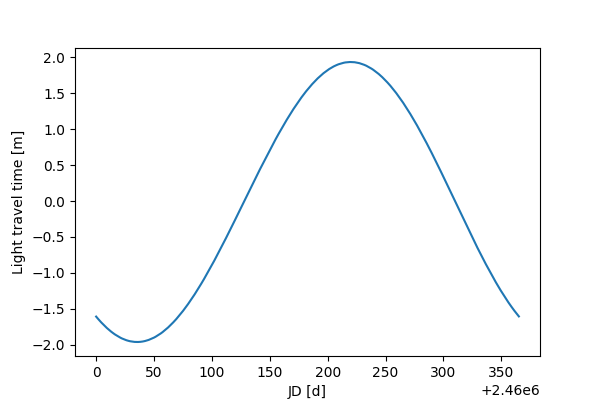

In [11]:
## install jplephem

from astropy.time import Time
# https://docs.astropy.org/en/stable/time/


# let's compute the light travel time for one year of observations 
jd_plot = np.arange(2460000, 2460365.25, 0.10) 
# Массив jd_plot представляет собой диапазон дат в формате Юлианских дат 
# (JD) на один год с шагом 0.10 дней

tm_plot = Time(jd_plot, format='jd', scale='utc', location=('45.8472d', '11.569d')) 
# Time - объект tm_plot создается с использованием JD и указанием местоположения 
# обсерватории через геодезические координаты


ltt_plot = tm_plot.light_travel_time(target, ephemeris='jpl')  
# вычисляет время, которое требуется свету чтобы придти от цели 
# к центру Солнечной системы с учетом эфемерид JPL
# (Jet Propulsion Laboratory, JPL)


bjd_tdb_plot = tm_plot.tdb + ltt_plot
# Convert to BJD_TDB, and then add the light travel time
# пределяет барицентрическое юлианское время (BJD_TDB) с учетом светового времени 
# ltt_plot : Рассчитывает, сколько времени потребуется свету, чтобы достичь 
# барицентра Солнечной системы от земли, учитывая эфемериды JPL

plt.figure(figsize=(6,4))
plt.plot(jd_plot, ltt_plot.to_value(u.min))
# Конструкция ltt_plot.to_value(u.min) преобразует значения времени распространения света, 
# содержащиеся в ltt_plot, в минуты. Вот пояснение:
# ltt_plot : Это объект, представляющий собой время, необходимое свету для путешествия 
# от наблюдаемого объекта к центру Солнечной системы. 
# Оно вычисляется с использованием эфемерид JPL
# to_value(u.min) : Этот метод преобразует величину времени, содержащуюся в ltt_plot, 
# в конкретные единицы — в данном случае, в минуты (u.min). Это делается для удобства чтения 
# и интерпретации данных на графике

plt.xlabel('JD [d]')
plt.ylabel('Light travel time [m]')
plt.show()

#### Information regarding the Light Travel Time calculation


`light_travel_time(skycoord, kind='barycentric', location=None, ephemeris=None)`

[link on astropy](https://docs.astropy.org/en/stable/api/astropy.time.Time.html#astropy.time.Time.light_travel_time)

Light travel time correction to the barycentre or heliocentre:

1. **Solar System Barycentre (SSB) :** Это центр масс всей Солнечной системы, учитывающий массу всех объектов, включая Солнце, планеты и другие тела
2. **Heliocentre :** Это точка в центре Солнца
Таким образом, барицентр Солнечной системы смещён относительно центра Солнца из-за гравитационного влияния планет

The frame transformations (математические преобразования, используемые для перевода координат небесных объектов из одной системы координат в другую) used to calculate the location of the solar system barycentre and the heliocentre rely on **the erfa routine epv00**

**"erfa routine epv00"** — это функция в библиотеке ERFA (Essential Routines for Fundamental Astronomy), обеспечивающая расчеты для определения положений и скоростей Земли и Солнца. Она основана на моделях и стандартов Международного астрономического союза (IAU). Эта рутина согласуется с эфемеридами JPL DE405, обеспечивая точные расчеты с погрешностью до 11.2 км

The routine assumes the source(s) are at large distance, i.e., neglects finite-distance effects

`Returns: time_offset TimeDelta`
The time offset between the barycentre or Heliocentre and Earth, in TDB seconds. 
Should be added to the original time to get the time in the Solar system barycentre or the Heliocentre
Also, the time conversion to BJD will then include the relativistic correction as well

Below, we compute the JD_UTC at mid exposure before converting to BJD_TDB

In [12]:
jd = array_jd + array_exptime/86400./2. 
# Здесь array_jd — это массив значений Julian Date, представляющий время начала наблюдений 
# the start time of observations
# array_exptime — это массив времени экспозиции в секундах  
# is an array of exposure times  
# Делением на 86400 переводим 
# секунды в дни, и добавлением половины этого времени смещаем метку на середину экспозиции

# Прибавляя половину времени экспозиции к времени начала наблюдений, 
# мы определяем среднее время, в которое свет фактически регистрировался детектором. 
# Это важно потому, что условия наблюдения, такие как движение Земли, 
# могут менять положение объектов на небе в течение экспозиции. 
# Среднее время позволяет более точно понимать, 
# в какой момент времени свет от объекта достиг телескопа в среднем

tm = Time(jd, format='jd', scale='utc', location=('45.8472d', '11.569d')) 
# В этой строке создаётся объект времени tm с использованием библиотеки Astropy
# Параметры:
#format='jd': Указывает, что входные данные в формате Julian Date
#scale='utc': Указывает, что Julian Date основаны на шкале UTC
#location=('45.8472d', '11.569d'): Координаты обсерватории Asiago - Cima Ekar, 
# используемые для вычислений

# Asiago - Cima Ekar
# 45° 50' 50'' N -> 45.8472
# 11° 34' 08'' E -> 11.569

ltt_bary = tm.light_travel_time(target)  
# Light travel time correction to the barycentre or heliocentre 
# Эта строка вычисляет время, нужное свету, чтобы достичь от цели 
# в центре масс Солнечной системы до обсерватории 
# Это время называется "временем светового пути" и учитывает поправку на движение Земли


bjd_tdb = tm.tdb + ltt_bary

print('Average Light travel time:                     {0:12.2f} minutes'.format(np.average(ltt_bary.to_value(u.min))))
print('Average difference between JD_UTC and BJD_TDB: {0:12.2f} seconds'.format(np.average(jd - bjd_tdb.to_value('jd'))*86400))

Average Light travel time:                            -1.82 minutes
Average difference between JD_UTC and BJD_TDB:        42.88 seconds
